In [46]:
using PyPlot 
using OrderedCollections 
using Roots

include("sim_steady_state.jl")

example_caliberation (generic function with 1 method)

In [2]:
# Initialization of ss policies 
y, _, Pi = discretize_income(0.975, 0.7, 7)
a_grid = discretize_assets(0, 10000, 500)
r = 0.01 / 4
beta = 1 - 0.08 / 4
eis = 1
ss = steady_state(Pi, a_grid, y, r, beta, eis)

Dict{String, Any} with 14 entries:
  "a_pi"   => [-0.0 -0.0 … 0.388295 0.386227; -0.0 -0.0 … 0.388496 0.386418; … …
  "c"      => [0.141369 0.146059 … 194.761 204.073; 0.250366 0.255056 … 194.959…
  "C"      => 1.00416
  "a_i"    => [0 0 … 498 499; 0 0 … 498 499; … ; 67 67 … 498 499; 134 134 … 498…
  "a_grid" => [0.0, 0.0046779, 0.00939966, 0.0141658, 0.0189769, 0.0238334, 0.0…
  "r"      => 0.0025
  "a"      => [0.0 0.0 … 9365.94 9821.07; 0.0 0.0 … 9365.85 9820.98; … ; 0.4364…
  "eis"    => 1
  "y"      => [0.141369, 0.250366, 0.4434, 0.785263, 1.39071, 2.46295, 4.3619]
  "A"      => 1.66451
  "D"      => [0.0152463 2.00327e-5 … 3.35158e-126 2.0877e-128; 0.0886728 0.000…
  "beta"   => 0.98
  "Va"     => [7.09135 6.86367 … 0.00514733 0.00491246; 4.00414 3.93052 … 0.005…
  "Pi"     => [0.927305 0.0704282 … 1.80817e-9 3.8147e-12; 0.011738 0.928048 … …

# Partial Equilibrium
- We are looking at how temporary shocks lead to deviation from steady state policies in our model.   

### Partial Equilibrium: backward iteration to obtain policy function

In [3]:
# Suppose at T = 5, there is a income shock were income grows by 1% (only for this period)
T = 11 # Calculate household response up to period 11
# Since outer prod not a function in julia if dims are different instead repeat income states T times with the 5th entry being the shock
ys = reshape(repeat(ss["y"], T), (length(ss["y"]), T))' # 'Repeat" repeats y 11 times with the dimension being forced to be 11 by 7
ys[6, :] = 1.01 .* ys[6, :]
ys

11×7 adjoint(::Matrix{Float64}) with eltype Float64:
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.142783  0.25287   0.447834  0.793116  1.40461  2.48758  4.40551
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619
 0.141369  0.250366  0.4434    0.785263  1.39071  2.46295  4.3619

In [4]:
# Now iterate backwards to get asset and consumption policies from T = 11 to 1
Va = ss["Va"]
# Create two empty arrays of size n_e x n_a x T (like endog grid that changes over time)
a = Array{Float64}(undef, T, size(ss["a"])...)
c = Array{Float64}(undef, T, size(ss["a"])...)

# For each period from 11 -> 1, caluculate the consumption and asset policy function
for t in reverse(1:T)
  Va, a[t, :, :], c[t, :, :] = backward_iteration(Va, Pi, a_grid, ys[t, :], r, beta, eis)
end

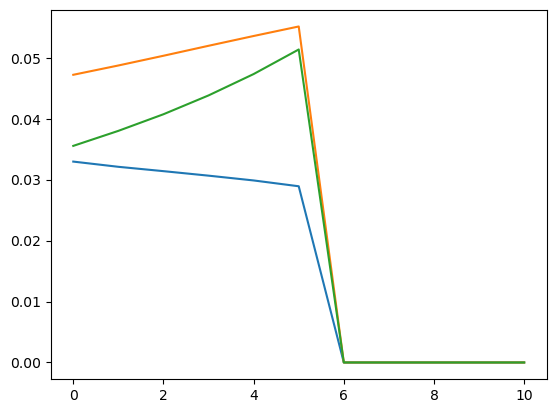

In [5]:
# We now plot policy functions (see how consumption policy changes-- % increase/decrease) due to shock
c_impulse = zeros(T, length(ss["y"]), length(ss["a_grid"])) #Change relative to ss
for t in 1:T
    c_impulse[t, :, :] = 100 * (c[t, :, :] .- ss["c"]) ./ ss["c"]
end
i_ave = argmax(ss["a_grid"] .> ss["A"])

for e in (1, 4, 7)
    plot(c_impulse[:, e, i_ave])
end

## Forward Iteration to obtain distribution

In [6]:
D = similar(a) #Like a, D is 3-d
D[1, :, :] = ss["D"]

# Get next period distribution
for t in 1:T-1
  a_i, a_pi = get_lottery(a[t, :, :], ss["a_grid"])
  D[t+1, :, :] = forward_iteration(D[t, :, :], ss["Pi"], a_i, a_pi)
end
D[11,:, :]

7×500 Matrix{Float64}:
 0.0152456   2.01346e-5   1.39563e-5   …  2.55718e-128  1.5843e-130
 0.0886567   0.000246858  0.000175217     1.53496e-127  9.50999e-130
 0.200932    0.00138848   0.000989626     3.85891e-127  2.39036e-129
 0.184338    0.00366283   0.00252144      5.2158e-127   3.22915e-129
 0.0068088   0.000137765  9.48029e-5      4.01544e-127  2.48336e-129
 8.53837e-5  1.73826e-6   1.19604e-6   …  1.68122e-127  1.03779e-129
 3.58578e-7  7.32262e-9   5.03819e-9      3.02393e-128  1.86064e-130

In [7]:
# Gets aggr. assets and consumption at each period 
A = zeros(T)
C = zeros(T)

for t in 1:T
  A[t] = vec(D[t, :, :])' * vec(a[t, :, :]) #Transposed so that indices line up correctly 
  C[t] = vec(D[t, :, :])' * vec(c[t, :, :])
end


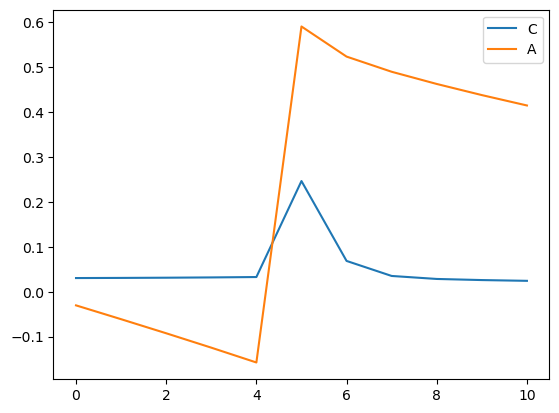

PyObject <matplotlib.legend.Legend object at 0x12340ee60>

In [8]:
# Figure out how aggr consumption and asset holdings change due to income shock (relative to the ss)
C_impulse = 100*(C .- ss["C"]) ./ss["C"]
A_impulse = 100*(A .- ss["A"]) ./ss["C"]
plot(C_impulse, label="C")
plot(A_impulse, label="A")
legend()

### Partial Equilibrium: General Code for any impulse


In [9]:
function policy_impulse(ss, shocks, T)
    
    Va = zeros(T, length(ss["y"]), length(ss["a_grid"]))
    a = zeros(T, length(ss["y"]), length(ss["a_grid"]))
    c = zeros(T, length(ss["y"]), length(ss["a_grid"]))

    inputs = Dict(k => ss[k] for k in ("Va", "Pi", "a_grid", "y", "r", "beta", "eis"))
                
    for t in reverse(1:T)
        for key in ("y", "r", "beta")
            if haskey(shocks, key) # Check shocks dictionary 
                delta = shocks[key][t, :] #Get the perturbations at time t for the shock 
                if length(size(delta)) == 1 && size(delta)[1] == 1
                    delta = delta[1] #If the perturbation only occurs for one period, delta is that perturbation, otherwise delta varies with time (outside of this if statement)
                end
                inputs[key] = ss[key] + delta
                Va[t, :, :], a[t, :, :], c[t, :, :] = backward_iteration(inputs["Va"], 
                                                                        inputs["Pi"], 
                                                                        inputs["a_grid"], 
                                                                        inputs["y"], 
                                                                        inputs["r"], 
                                                                        inputs["beta"], 
                                                                        inputs["eis"])
            end
        end
        inputs["Va"] = Va[t, :, :] # Update marginal value function
    end
        
    return Va, a, c
end  

policy_impulse (generic function with 1 method)

In [10]:
# Testing that the code works
ys_test = similar(ys)
for t in 1:T
    ys_test[t, :] = ys[t, :] - ss["y"]
end

test_dict = Dict("y" => ys_test)
_, a_alt, c_alt = policy_impulse(ss, test_dict, T)

([7.091350817390766 4.004137654315951 … 0.4944851338022137 0.33403316419336077; 7.091350817390766 4.004137654315951 … 0.49447096996993056 0.33402430200390903; … ; 7.091350817390766 4.004137654315951 … 0.49469477188591543 0.334157199559678; 7.091350817390766 4.004137654315951 … 0.49469477188591543 0.334157199559678;;; 6.863665102262849 3.930515380321836 … 0.4944269949898405 0.33401352477596574; 6.863665102262849 3.930515380321836 … 0.4944128471530043 0.3340046633356901; … ; 6.863665102262849 3.930515380321836 … 0.4946365088243487 0.33413753524164524; 6.863665102262849 3.930515380321836 … 0.4946365088243487 0.33413753524164524;;; 6.694213296253943 3.861828336734923 … 0.49436835934918105 0.33399370352743424; 6.694213296216547 3.8618283361477346 … 0.49435422630106457 0.3339848428432437; … ; 6.694213296394612 3.8618283418653028 … 0.49457776146954135 0.3341176888640353; 6.694213296394612 3.8618283418653028 … 0.49457776146954135 0.3341176888640353;;; … ;;; 0.005392097295633306 0.0053863822743

In [11]:
function distribution_impulse(ss, a, T)
  D = similar(a)
  D[1, :, :] = ss["D"] # First layer is the steady state

  for t in 1:T-1
    a_i, a_pi = get_lottery(a[t, :, :], ss["a_grid"])
    D[t+1, :, :] = forward_iteration(D[t, :, :], ss["Pi"], a_i, a_pi)
  end
  return D
end

distribution_impulse (generic function with 1 method)

In [12]:
# Computes impulse (changes to policy and consumption functions | in addition to aggr A and C)
function household_impulse(ss, shocks, T)
  Va, a, c = policy_impulse(ss, shocks, T)
  D = distribution_impulse(ss, a, T)

  A = zeros(T)
  C = zeros(T)
  # Return aggregate asset holdings and consumption 
  for t in 1:T
    A[t] =  vec(D[t, :, :])' * vec(a[t, :, :]) #Transposed so that indices line up correctly 
    C[t] =  vec(D[t, :, :])' * vec(c[t, :, :])
  end
  return Dict(
    "D" => D,
    "Va" => Va,
    "a" => a,
    "c" => c,
    "A" => A,
    "C" => C
  )
end

household_impulse (generic function with 1 method)

In [13]:
# Testing household impulse
impulse = household_impulse(ss, test_dict, T)

Dict{String, Array{Float64}} with 6 entries:
  "A"  => [1.6642, 1.66389, 1.66358, 1.66325, 1.66292, 1.67044, 1.66977, 1.6694…
  "c"  => [0.141369 0.250366 … 2.02736 3.0012; 0.141369 0.250366 … 2.02742 3.00…
  "C"  => [1.00447, 1.00447, 1.00447, 1.00448, 1.00449, 1.00664, 1.00485, 1.004…
  "D"  => [0.0152463 0.0886728 … 8.57025e-5 3.59922e-7; 0.0152463 0.0886728 … 8…
  "a"  => [0.0 0.0 … 0.435587 1.3607; 0.0 0.0 … 0.435529 1.36062; … ; 0.0 0.0 ……
  "Va" => [7.09135 4.00414 … 0.494485 0.334033; 7.09135 4.00414 … 0.494471 0.33…

### Partial Eq consumption response to different return shocks 


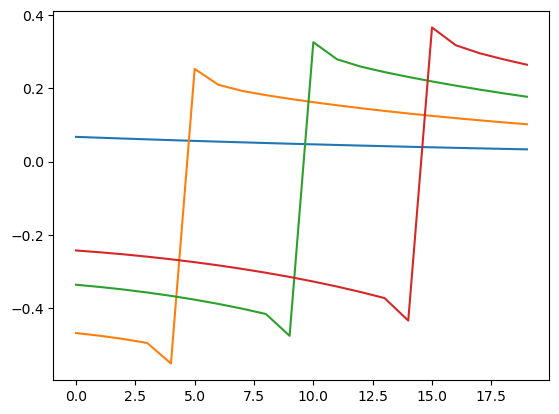

In [14]:
# Gives different consumption functions given shocks at different times
for t in (1, 6, 11, 16)
  r_shock = zeros(20, 1) # 20x1 array
  r_shock[t, 1] = 0.01 #At time t, 1% shock
  r_dict = Dict("r" => r_shock)
  plot(100 .* (household_impulse(ss, r_dict, 20)["C"] .- ss["C"]) ./ ss["C"], label = "shocks at $(t-1)")
end

## General Equilibrium

In [15]:
# Calibration:
B = 5.6   # annual bonds/GDP is 140%, so quarterly is 560%, and quarterly GDP is 1
tau = ss["r"]*B # labor tax needed to balance steady-state government budget
e = ss["y"]     # use our previous y, which had mean 1, for the labor endowment process

# Get beta such that asset market clears (when A, assets held by household = B, assets issued by govt)
function objective_function(beta)
  # Get aggregate assets in economy (want to minimize the difference between A and B)
  return steady_state(ss["Pi"], ss["a_grid"], (1 - tau) * e, ss["r"], beta, ss["eis"])["A"] - B
end

# Find root (B s.t A-B=0)
beta_ge = find_zero(objective_function, (0.98, 0.995), Bisection())

# Calculate ss with the asset clearing beta
ss_ge = steady_state(ss["Pi"], ss["a_grid"], (1 - tau) * e, ss["r"], beta_ge, ss["eis"])
# Check asset market clearing (market clears when difference small enough)

Dict{String, Any} with 14 entries:
  "a_pi"   => [-0.0 -0.0 … 0.217793 0.216538; -0.0 -0.0 … 0.21782 0.216564; … ;…
  "c"      => [0.13939 0.14408 … 119.77 125.457; 0.246861 0.25155 … 119.889 125…
  "C"      => 1.0
  "a_i"    => [0 0 … 498 499; 0 0 … 498 499; … ; 96 97 … 498 499; 159 159 … 498…
  "a_grid" => [0.0, 0.0046779, 0.00939966, 0.0141658, 0.0189769, 0.0238334, 0.0…
  "r"      => 0.0025
  "a"      => [0.0 0.0 … 9440.93 9899.68; 0.0 0.0 … 9440.92 9899.67; … ; 0.7563…
  "eis"    => 1
  "y"      => [0.13939, 0.246861, 0.437192, 0.77427, 1.37124, 2.42847, 4.30083]
  "A"      => 5.6
  "D"      => [0.0131548 7.68982e-5 … 7.71688e-106 5.57939e-108; 0.0692791 0.00…
  "beta"   => 0.987786
  "Va"     => [7.19204 6.95795 … 0.00837023 0.00799076; 4.06099 3.98528 … 0.008…
  "Pi"     => [0.927305 0.0704282 … 1.80817e-9 3.8147e-12; 0.011738 0.928048 … …

In [16]:
# Choose shock to Xt (ie. productivity) (increases by 1% each period)
T = 300
Xs = 1 .+ 0.01 .* 0.95 .^ collect(0:T-1)

300-element Vector{Float64}:
 1.01
 1.0095
 1.009025
 1.00857375
 1.0081450625
 1.007737809375
 1.00735091890625
 1.0069833729609374
 1.0066342043128906
 1.006302494097246
 1.0059873693923838
 1.0056880009227647
 1.0054036008766263
 ⋮
 1.0000000038405934
 1.0000000036485637
 1.0000000034661354
 1.0000000032928287
 1.0000000031281873
 1.000000002971778
 1.000000002823189
 1.0000000026820295
 1.000000002547928
 1.0000000024205318
 1.000000002299505
 1.00000000218453

### GE impulse responses: finding r path that clears market across all periods

In [17]:
# Setting up function mapping r path to asset market clearing erro
pi = sum(ss_ge["D"], dims=2) #ss distribution of s

function impulse_map(rs, Xs)
  #gov budget must balance at each time t: tau_t = r_t * B
  taus = rs * B
  ys = (Xs .- taus) * e'
  # Set up perturbations (r)
  r_delta = rs .- ss_ge["r"]
    
  # Set up perturbations (y)  
  ys_delta_matrix = similar(ys)
  for t in 1:T
    ys_delta_matrix[t, :] = ys[t, :] - ss_ge["y"]
  end
    
  shocks = Dict("r" => r_delta, "y" => ys_delta_matrix)
    
  impulse = household_impulse(ss_ge, shocks, length(rs))
    
  return impulse["A"] .- B, impulse
end

impulse_map (generic function with 1 method)

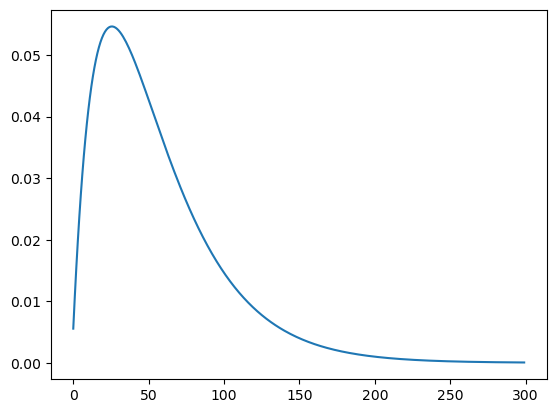

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x123913430>

In [18]:
asset_mkt_error, _ = impulse_map(fill(ss_ge["r"], T), Xs)
plot(asset_mkt_error)

## Sequence-Space Jacobians to Iterate over guesses (Calculate Jacobian)

In [19]:
# Calculate Jacobian (matrix of derivatives) for shocks at each period in time
J = zeros(T,T)
h = 1E-4
no_shock = impulse_map(fill(ss_ge["r"], T), 1)[1]
for tshock in 1:T
    J[:, tshock] = (impulse_map(ss_ge["r"] .+ h .* (collect(1:T) .== tshock), 1)[1] .- no_shock) / h
end


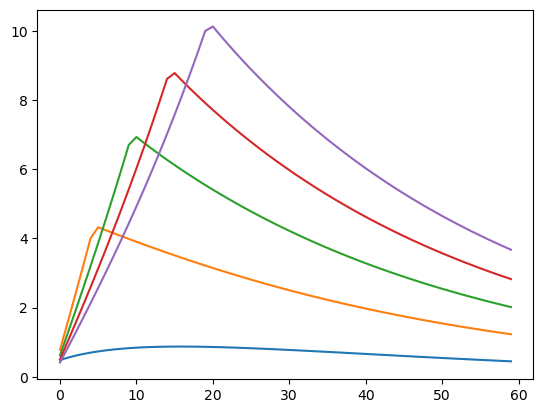

In [20]:
# Plotting Jacobians
for t in (1, 6, 11, 16, 21)
    plot(J[1:60, t])
end

## Using this Jacobian to Update Guesses

Asset market clearing up to 12 digits after 6 iterations

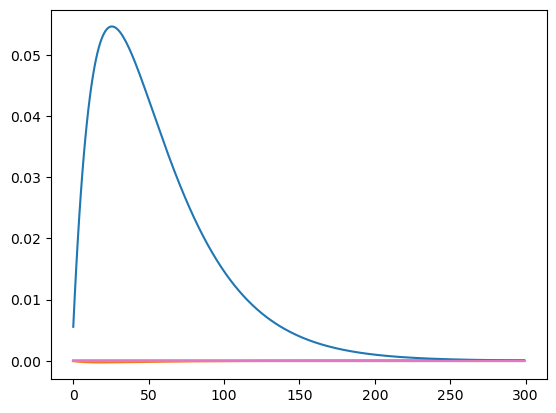

In [21]:
rs = fill(ss_ge["r"], T) # initial guess constant
Jbar = J[1:T-1, 2:T] # Jbar for our guesses eliminates last row and first column
for it in 0:29
    asset_mkt_error, impulse = impulse_map(rs, Xs)
    plot(asset_mkt_error, label="iteration $it")
    err = maximum(abs.(asset_mkt_error[1:T-1])) # solve for asset market clearing at 0, 1, ..., T-2
    if err < 1E-10
        print("Asset market clearing up to 12 digits after $it iterations")
        break
    end
    rs[2:T] .-= Jbar \ asset_mkt_error[1:T-1] # adjust r_1, ..., r_(T-1) (all entries)
end

## Fake News Algorithm 

### (Insight 1) Symmetry in Backwards Iteration 
See OG Python Notebook for example of why time til shock changes household policy decision and not when shock occurs

In [22]:
#impulse_s4 = zeros(T, size(ss_ge["a"],1), size(ss_ge["a"],2))
#impulse_s5 = zeros(T, size(ss_ge["a"],1), size(ss_ge["a"],2))
#impulse_s6 = zeros(T, size(ss_ge["a"],1), size(ss_ge["a"],2));

#for i in 1:T
#    impulse_s4[i, :, :] = (impulse_map(ss_ge["r"] .+ h .* (collect(0:T-1) .== 4), 1)[2]["a"][i, :, :] .- ss_ge["a"]) ./ h
#    impulse_s5[i, :, :] = (impulse_map(ss_ge["r"] .+ h .* (collect(0:T-1) .== 5), 1)[2]["a"][i, :, :] .- ss_ge["a"]) ./ h
#    impulse_s6[i, :, :] = (impulse_map(ss_ge["r"] .+ h .* (collect(0:T-1) .== 6), 1)[2]["a"][i, :, :] .- ss_ge["a"]) ./ h
#end

'\'': ASCII/Unicode U+0027 (category Po: Punctuation, other)

### Using Symmetry to Build Jacobian of impulse_map

In [26]:
shock_dims = size(impulse_map(ss_ge["r"] .+ h .* (collect(1:T) .== T-1), 1)[2]["a"]) #300x7x500 matrix
da = zeros(shock_dims) #Path of the difference in policy function across all periods

for t in 1:T #At each period, we look at how the policy function changes relative to the steady state policy function path store at da[t, :, :]
    da[t, :, :] = impulse_map(ss_ge["r"] .+ h .* (collect(0:T-1) .== T-1), 1)[2]["a"][t, :, :] .- ss_ge["a"] # "a" is the policy function at all t (s.s)
end


In [34]:
@time begin
    J_alt = zeros(T,T)
    a_ss = zeros(shock_dims)

    # Construct ss policy function over t in [1,T]
    for i in 1:T
        a_ss[i, :, :] = ss_ge["a"]
    end

    for s in 0:T-1
        a = copy(a_ss) # Make a copy of the steady state policy function
        # The perturbed policy function is the steady_state + the change in a (following the shock)
        # First index is time, so from period 1 to s+1; da 
        a[1:s+1, :, :] += da[T-s:end, :, :]
        D = distribution_impulse(ss_ge, a, T)
        A = sum(a .* D, dims = (2, 3))
        J_alt[:, s+1] = (A .- B .- no_shock) ./ h # NOTE: no_shock is slightly different from the Python version
    end
    # print(D)
    # print(A)
end

 39.396301 seconds (1.54 M allocations: 27.009 GiB, 7.97% gc time)


In [35]:
# Make sure both Jacobians are the same
maximum(abs.(J_alt - J))

2.842170943040401e-10

### Insight 2 (Getting anticipation effects: F-Matrix)

In [38]:
# We are calculating F, which characterizes the difference in the diagonal jacobian entries (bottom diag - top). This
# reflects that households have one more period to smoothe over their consumption (in anticipation of the shock) by changing their aggregate asset holdings
# F_alt is not the analytic way of getting F (by subtracting diagonal entries), it is done by manually populating F_alt with the difference in the impulse reponse between periods t and t-1
@time begin
    F_alt = zeros(T, T)
    for s in 0:T-1
        # calculate impulse response to anticipation of date-s shock at date 0
        a = copy(a_ss)
        a[1, :, :] += da[T-s, :, :]
        D = distribution_impulse(ss_ge, a, T)
        A = sum(a .* D, dims=(2, 3))
        F_alt[:, s+1] = (A .- B .- no_shock) ./ h
    end
end  

 36.470512 seconds (1.54 M allocations: 23.493 GiB, 7.41% gc time)


In [41]:
F = copy(J)
F[2:end, 2:end] -= J[1:end-1, 1:end-1] # Subtracting the diagonal entries from the first jacobian (analytic way)

299×299 Matrix{Float64}:
 0.903655     0.864052     0.82442      …  7.59369e-6  7.28806e-6  6.99471e-6
 0.862541     0.826159     0.791002        7.44681e-6  7.1471e-6   6.85942e-6
 0.826114     0.791918     0.759215        7.30305e-6  7.0091e-6   6.72699e-6
 0.792844     0.760558     0.729673        7.16224e-6  6.87394e-6  6.59727e-6
 0.761941     0.731355     0.7021          7.02424e-6  6.74151e-6  6.47017e-6
 0.733081     0.704028     0.67624      …  6.88901e-6  6.61172e-6  6.3456e-6
 0.705995     0.678335     0.651882        6.75644e-6  6.48449e-6  6.22348e-6
 0.680472     0.654091     0.628864        6.62646e-6  6.35974e-6  6.10374e-6
 0.656361     0.63116      0.607062        6.49899e-6  6.23739e-6  5.98632e-6
 0.633531     0.609423     0.586371        6.37396e-6  6.1174e-6   5.87117e-6
 0.61187      0.588778     0.566698     …  6.2513e-6   5.99967e-6  5.75818e-6
 0.591282     0.569138     0.547964        6.13094e-6  5.88416e-6  5.64732e-6
 0.571673     0.550415     0.530088     

In [42]:
maximum(abs.(F_alt - F)) #Both ways of constructing the F matrix are the same

6.712005173881153e-5

In [40]:
# You can construct the first Jacobian w/ entries J_{t,s} by just taking jacobian J_{t-1,s-1} and adding the F matrix (the difference of the two) 
function J_from_F(F)
    J = copy(F)
    for t in 1:size(F, 1)-1
        J[2:end, t+1] += J[1:end-1, t]
    end
    return J
end

# Should be the same Jacobian matrix (one creating from the F matrix, and the other we calculated in cell 30)
maximum(abs.(J_from_F(F_alt) - J))

0.0017242318861576678

### Insight 3: Using expectation functions
Essentially, although the policy function goes back to the steady state (see cell 28 after shock in r), distribution is changed due to anticipatory effects (which also characterize non-equal jacobian diagonals for the aggregate assets). We can forecast the long term effect to the distribution using expectation functions

In [48]:
# CurlyE gives the expected asset value at each horizon given today's state
@time begin
    curlyE = expectation_functions(ss_ge["a"], ss_ge["Pi"], ss_ge["a_i"], ss_ge["a_pi"], T)
end;

  0.058966 seconds (1.80 k allocations: 32.032 MiB)


### Full "Fake News Algorithm": Build entire F matrix with this, get J

In [66]:
@time begin
    F = zeros(T,T)
    D1_noshock = forward_iteration(ss_ge["D"], ss_ge["Pi"], ss_ge["a_i"], ss_ge["a_pi"])

for s in 0:T-1
    # F_(1,s+1): change in asset policy times steady-state incoming distribution
    F[1, s+1] = dot(ss_ge["D"], da[T-s, :, :]) / h
        # change in D_1 from this change
        a_i_shocked, a_pi_shocked = get_lottery(ss_ge["a"] + da[T-s, :, :], ss_ge["a_grid"])
        d_D1 = forward_iteration(ss_ge["D"], ss_ge["Pi"], a_i_shocked, a_pi_shocked) - D1_noshock
        # use expectation vectors to project effect on aggregate
        F[2:end, s+1] = (reshape(curlyE[1:T-1, : , :], T-1, :) * vec(d_D1)) / h
J_alt = J_from_F(F)
end
end

  2.685539 seconds (282.91 k allocations: 3.255 GiB, 27.95% gc time)


In [67]:
maximum(abs.(J_alt - J))

0.001724232640086143

## Summary and General Code for Fake News Algorithm

### Code for Step 1

In [93]:
function step1_backward(ss, shock, T, h)
    # preliminaries: D_1 with no shock, ss inputs to backward_iteration
    D1_noshock = forward_iteration(ss["D"], ss["Pi"], ss["a_i"], ss["a_pi"])
    ss_inputs = Dict(k => ss[k] for k in ("Va", "Pi", "a_grid", "y", "r", "beta", "eis"))
    Va = ss_inputs["Va"]

    # allocate space for results
    curlyY = Dict("A" => zeros(T), "C" => zeros(T))
    curlyD = similar(ss["D"], T, size(ss["D"])...)

    # backward iterate
    for s in 1:T
        if s == 0
            # at horizon of s=0, 'shock' actually hits, override ss_inputs with shock
            shocked_inputs = Dict(k => ss[k] + h*shock[k] for k in keys(shock))
            # Air-lifted from Sophia
            Va, a, c = backward_iteration(merge(ss_inputs, shocked_inputs)["Va"], 
                                          merge(ss_inputs, shocked_inputs)["Pi"], 
                                          merge(ss_inputs, shocked_inputs)["a_grid"], 
                                          merge(ss_inputs, shocked_inputs)["y"],
                                          merge(ss_inputs, shocked_inputs)["r"], 
                                          merge(ss_inputs, shocked_inputs)["beta"], 
                                          merge(ss_inputs, shocked_inputs)["eis"])
        else
            # Air-lifted from Sophia
            # now the only effect is anticipation, so it's just Va being different
            Va, a, c = backward_iteration(merge(ss_inputs, Dict("Va" => Va))["Va"], 
                                          merge(ss_inputs, Dict("Va" => Va))["Pi"], 
                                          merge(ss_inputs, Dict("Va" => Va))["a_grid"], 
                                          merge(ss_inputs, Dict("Va" => Va))["y"], 
                                          merge(ss_inputs, Dict("Va" => Va))["r"], 
                                          merge(ss_inputs, Dict("Va" => Va))["beta"], 
                                          merge(ss_inputs, Dict("Va" => Va))["eis"])
        end
        
        # aggregate effects on A and C
        curlyY["A"][s] = dot(ss["D"], a - ss["a"]) ./ h
        curlyY["C"][s] = dot(ss["D"], c - ss["c"]) ./ h
        
        # what is effect on one-period-ahead distribution?
        a_i_shocked, a_pi_shocked = get_lottery(a, ss["a_grid"])
        curlyD[s, :, :] = (forward_iteration(ss_ge["D"], ss_ge["Pi"], a_i_shocked, a_pi_shocked) - D1_noshock) / h
    end
    
    return curlyY, curlyD
end

step1_backward (generic function with 1 method)

### Code for Step 2 (ie. putting all steps together)

In [91]:
function jacobian(ss, shocks, T)
    # step 1 for all shocks i, allocate to curlyY[o][i] and curlyD[i]
    curlyY = Dict("A" => Dict(), "C" => Dict())
    curlyD = Dict()
    for (i, shock) in shocks
        curlyYi, curlyD[i] = step1_backward(ss, shock, T, 1E-4)
        curlyY["A"][i], curlyY["C"][i] = curlyYi["A"], curlyYi["C"]
    end
    
    # step 2 for all outputs o of interest (here A and C)
    curlyE = Dict()
    for o in ("A", "C")
        curlyE[o] = expectation_functions(ss[lowercase(o)], ss["Pi"], ss["a_i"], ss["a_pi"], T-1)
    end
    
    # steps 3 and 4: build fake news matrices, convert to Jacobians
    Js = Dict("A" => Dict(), "C" => Dict())
    for o in keys(Js)
        for i in keys(shocks)
            F = zeros(T, T)
            F[1, :] = curlyY[o][i]
            F[2:end, 1:end] = reshape(curlyE[o], T-1, :) * reshape(curlyD[i], T, :)' #For respective policy or consumption function impulses, multiply by distribution
            Js[o][i] = J_from_F(F)
        end
    end
    print(Js["A"]["r_direct"])
    return Js
end 


jacobian (generic function with 1 method)

### Applying SS-Jacobians

In [94]:
@time begin
    Js = jacobian(ss_ge, Dict("r_direct" => Dict("r" => 1), "X" => Dict("y" => e), "T" => Dict("y" => ones(size(e)))), T)
end

J_alt2 = Js["A"]["r_direct"] - B*Js["A"]["X"]


[1.4013392646685392e-14 -4.622759395993765e-14 -4.64290373400547e-14 -9.557234427850602e-14 -7.332276393574822e-14 -1.2472717478301572e-13 -1.0155882220714646e-13 -1.4067973096974456e-13 -1.2828770586570889e-13 -1.7380443662445837e-13 -1.6116096473781814e-13 -2.0898159377010913e-13 -1.8924557415729215e-13 -2.1769402482110831e-13 -1.9540998202013616e-13 -2.283962903260993e-13 -1.970140045634387e-13 -2.365352297320167e-13 -2.086990972823898e-13 -2.383045140809153e-13 -2.1712397789109084e-13 -2.5238810328825156e-13 -2.209060111572486e-13 -2.5552313317929225e-13 -2.2487815147689907e-13 -2.4996388773682124e-13 -2.252590802489551e-13 -2.552578772513648e-13 -2.20894497247915e-13 -2.5552933263674703e-13 -2.2488966538623273e-13 -2.499576882793665e-13 -2.2524756633962145e-13 -2.552640767088195e-13 -2.209060111572486e-13 -2.5552313317929225e-13 -2.2487815147689907e-13 -2.4996388773682124e-13 -2.252590802489551e-13 -2.552578772513648e-13 -2.20894497247915e-13 -2.5552933263674703e-13 -2.24889665386

Excessive output truncated after 524305 bytes.

 -7.006887590714042e-12 -7.005882624773771e-12 -7.006317931744007e-12 -6.9956017074811e-12 -7.018902748630989e-12 -6.996946313746037e-12 -7.006645649521477e-12 -7.005937546758163e-12 -7.006319145611828e-12 -6.995300650341225e-12 -7.018850421845025e-12 -6.99719517660277e-12 -7.006887590714044e-12 -7.0058826247737725e-12 -7.006317931744007e-12 -6.995601707481098e-12 -7.018902748630989e-12 -6.996946313746037e-12 -7.006645649521475e-12 -7.005937546758163e-12 -7.006319145611831e-12 -6.995300650341225e-12 -7.018850421845025e-12 -6.99719517660277e-12 -7.006887590714044e-12 -7.0058826247737725e-12 -7.006317931744007e-12 -6.995601707481098e-12 -7.018902748630989e-12 -6.996946313746036e-12 -7.006645649521475e-12 -7.005937546758162e-12 -7.006319145611829e-12 -6.995300650341223e-12 -7.018850421845023e-12 -6.99719517660277e-12 -7.006887590714044e-12 -7.0058826247737725e-12 -7.006317931744006e-12 -6.995601707481098e-12 -7.018902748630986e-12 -6.996946313746037e-12 -7.006645649521475e-12 -7.005937546

300×300 Matrix{Float64}:
 -6.44616e-14   2.12647e-13   2.13574e-13  …  1.01617e-12  1.17541e-12
 -6.56322e-13   2.38569e-13  -2.17401e-13     1.57075e-12  2.1634e-12
 -6.59758e-13  -3.5728e-13   -1.96557e-13     2.63475e-12  2.70222e-12
 -6.62661e-13  -3.64675e-13  -7.96968e-13     3.08418e-12  3.75068e-12
 -6.65056e-13  -3.71509e-13  -8.08434e-13     4.08314e-12  4.18478e-12
 -6.66966e-13  -3.77808e-13  -8.18869e-13  …  4.59996e-12  5.16861e-12
 -6.68415e-13  -3.83597e-13  -8.28321e-13     5.51099e-12  5.67051e-12
 -6.69431e-13  -3.88897e-13  -8.36842e-13     5.97409e-12  6.56682e-12
 -6.70047e-13  -3.9374e-13   -8.44489e-13     6.94786e-12  7.01538e-12
 -6.70294e-13  -3.98159e-13  -8.51318e-13     7.30944e-12  7.9748e-12
 -6.7019e-13   -4.02183e-13  -8.57382e-13  …  8.22511e-12  8.32221e-12
 -6.69748e-13  -4.05832e-13  -8.62722e-13     8.65969e-12  9.22389e-12
 -6.68984e-13  -4.09118e-13  -8.67372e-13     9.48933e-12  9.64463e-12
  ⋮                                        ⋱          